### In the end, this tutorial turned into a demonstration of how the interpolator does not work well enough.
___


## A tutorial for the CMNN Interpolator
By Marcquis Harris and Melissa Graham, University of Washington. <br>
Saturday April 18, 2020 <br>

### What does the CMNN Interpolator do?
The CMNN Interpolator returns a predicted robust standard deviation and error, robust bias and error, and fraction of outliers for photometric redshift estimates of LSST galaxies for a user-input set of 5-sigma liming magnitudes in LSST filters ugrizy at a desired redshift between 0.3 and 3.0. <br>

### Command line use of "cmnn_interpolator.py"
The CMNN Interpolator can be called from the command line as follows: <br> 
<br>
python cmnn_interpolator.py -user_maglims 26.1 27.4 27.5 26.8 26.1 24.9 -user_redshift 0.35 <br>
<br>
__Inputs:__ A set of six 5-sigma limiting magnitudes, one for each filter ugrizy (in that order), and a redshift.<br>
Minimum acceptable limiting magnitudes: 23.90, 25.00, 24.70, 24.00, 23.30, 22.10 (single-visit depths)<br>
Maximum acceptable limiting magnitudes: 26.78, 27.88, 27.84, 27.15, 26.37, 25.17 (max simulated) <br>
Acceptable redshift range: 0.3 to 3.0. <br>
__Actions:__ User input is checked for compliance with the boundaries. If the input is not within acceptable range an error message is returned and no interpolation is done. Otherwise, the inputs are passed to the module "return_interp_stats". This module determines the appropriate bin for the user-supplied redshift, unpickles the appropriate linear regression models for the photo-z quality statistics, interpolates at the user's input 5-sigma limiting magnitudes, and returns the predicted statistics in a 5-element array: robust standard deviation and error, robust bias and error, and fraction of outliers. It also returns the center of the redshift bin as a 1-element float. <br>
__Outputs:__ The redshift bin center and interpolated statistics are printed to screen. <br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmnn_interpolator
import warnings
warnings.filterwarnings('ignore')

### Use the interpolator to return predicted photo-z statistics.

In [2]:
my_maglims = np.asarray( [26.085, 27.379, 27.531, 26.831, 26.055, 24.855], dtype='float' )
my_redshift = float(0.99)

zbin,stats = cmnn_interpolator.return_interp_stats( my_maglims, my_redshift )

print( ' ' )
print( 'Redshift bin center:', zbin )
print( ' ' )
print( 'Predicted statistics (value, error):' )
print( 'robust standard deviation   %10.6f %10.6f ' % ( stats[0], stats[1] ) )
print( 'robust bias                 %10.6f %10.6f ' % ( stats[2], stats[3] ) )
print( 'fraction of outliers        %10.6f '        % stats[4] )

del my_maglims,my_redshift,zbin,stats

 
Redshift bin center: 1.05
 
Predicted statistics (value, error):
robust standard deviation     0.017813   0.000224 
robust bias                   0.000804   0.000080 
fraction of outliers          0.043017 


### Failure mode: NaN are returned if input values are outside the acceptable range.

In [3]:
# my_maglims = np.asarray( [26.085, 27.379, 27.531, 26.831, 26.055, 24.855], dtype='float' )
# my_maglims = np.asarray( [26.78,27.88,27.84,27.15,26.37,25.17], dtype='float' )
my_maglims = np.asarray( [23.90,25.00,24.70,24.00,23.30,21.50], dtype='float' )

# my_redshift = float(3.99)
my_redshift = float(0.5)

zbin,stats = cmnn_interpolator.return_interp_stats( my_maglims, my_redshift )

print( ' ' )
print( 'Redshift bin center:', zbin )
print( ' ' )
print( 'Predicted statistics (value, error):' )
print( 'robust standard deviation   %10.6f %10.6f ' % ( stats[0], stats[1] ) )
print( 'robust bias                 %10.6f %10.6f ' % ( stats[2], stats[3] ) )
print( 'fraction of outliers        %10.6f '        % stats[4] )

del my_maglims,my_redshift,zbin,stats

 
Redshift bin center: nan
 
Predicted statistics (value, error):
robust standard deviation          nan        nan 
robust bias                        nan        nan 
fraction of outliers               nan 


### Demonstration: Plot predicted photo-z statisics as a function of redshift
In this example, we compare the predicted photo-z statistics of robust standard deviation, robust bias, and fraction of outliers for three LSST observing strategies: the 10-year baseline, and the 10-year baseline when half or double the amount of time is spent on the g-band filter. In this example, time is taken/given to the g-band filter without giving/taking from the other filters (i.e., total amount of survey time is not conserved).<br>
<br>
**This ended up just demonstrating the failure of the interpolator.** We also plot the UNINTERPOLATED baseline results in light blue, so that we can assess how well the interpolator is performing. Compare with the dark blue line, which should match identically, and we can see that the interpolator does not return accurate values. <br>

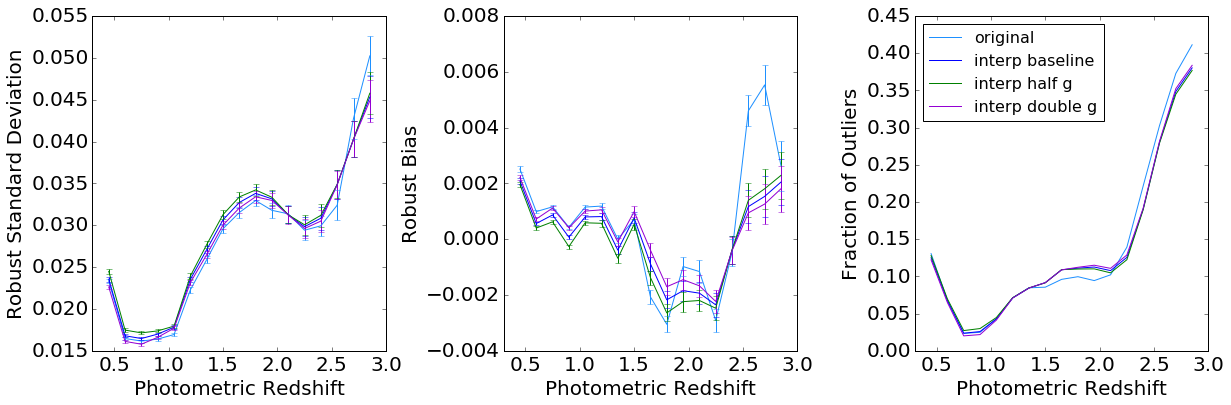

In [4]:
### Get the uninterpolated baseline results from the gridded data input to the linear regression models
bl_z = np.loadtxt( 'grid_statistics/grid_zbins.dat', dtype='float' )
cols = np.arange( 17, dtype='int' ) + 6
bl_stdd    = np.loadtxt( 'grid_statistics/grid_stdd.dat',    dtype='float', usecols=cols )[0]
bl_stdderr = np.loadtxt( 'grid_statistics/grid_stdderr.dat', dtype='float', usecols=cols )[0]
bl_bias    = np.loadtxt( 'grid_statistics/grid_bias.dat',    dtype='float', usecols=cols )[0]
bl_biaserr = np.loadtxt( 'grid_statistics/grid_biaserr.dat', dtype='float', usecols=cols )[0]
bl_fout    = np.loadtxt( 'grid_statistics/grid_fout.dat',    dtype='float', usecols=cols )[0]

### Three sets of 5-sigma limiting magnitudes to submit to the interpolotor:
###   baseline 10-year LSST observing strategy
###   as above, but the g-band exposure time is halved
###   as above, but the g-band exposure time is doubled
maglims_baseline = np.asarray( [26.09, 27.38, 27.53, 26.83, 26.05, 24.86], dtype='float' )
maglims_ghalf    = np.asarray( [26.09, 27.00, 27.53, 26.83, 26.05, 24.86], dtype='float' )
maglims_gdouble  = np.asarray( [26.09, 27.76, 27.53, 26.83, 26.05, 24.86], dtype='float' )

redshifts      = np.arange( 17, dtype='float' )*0.15 + 0.45
stats_baseline = np.zeros( (17,5), dtype='float' )
stats_ghalf    = np.zeros( (17,5), dtype='float' )
stats_gdouble  = np.zeros( (17,5), dtype='float' )

for r,redshift in enumerate(redshifts):
    zbin1,stats1 = cmnn_interpolator.return_interp_stats( maglims_baseline, redshift )
    zbin2,stats2 = cmnn_interpolator.return_interp_stats( maglims_ghalf, redshift )
    zbin3,stats3 = cmnn_interpolator.return_interp_stats( maglims_gdouble, redshift )
    for s in range(5):
        stats_baseline[r,s] = stats1[s]
        stats_ghalf[r,s]    = stats2[s]
        stats_gdouble[r,s]  = stats3[s]
    del zbin1,stats1,zbin2,stats2,zbin3,stats3
    

### Make plots of standard deviation, bias, and fraction of outliers as a function of redshift
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,6) )
plt.rcParams.update( {'font.size':20} )

ax1.errorbar( bl_z, bl_stdd, bl_stdderr, color='dodgerblue',label='original')
ax1.errorbar( redshifts, stats_baseline[:,0], stats_baseline[:,1], color='blue',       label='baseline' )
ax1.errorbar( redshifts, stats_ghalf[:,0],    stats_ghalf[:,1],    color='green',      label='half g' )
ax1.errorbar( redshifts, stats_gdouble[:,0],  stats_gdouble[:,1],  color='darkviolet', label='double g' )
ax1.set_xlim([0.3,3.0])
ax1.set_xlabel('Photometric Redshift')
ax1.set_ylabel('Robust Standard Deviation')

ax2.errorbar( bl_z, bl_bias, bl_biaserr, color='dodgerblue',label='original')
ax2.errorbar( redshifts, stats_baseline[:,2], stats_baseline[:,3], color='blue',       label='baseline' )
ax2.errorbar( redshifts, stats_ghalf[:,2],    stats_ghalf[:,3],    color='green',      label='half g' )
ax2.errorbar( redshifts, stats_gdouble[:,2],  stats_gdouble[:,3],  color='darkviolet', label='double g' )
ax2.set_xlim([0.3,3.0])
ax2.set_xlabel('Photometric Redshift')
ax2.set_ylabel('Robust Bias')

ax3.plot( bl_z, bl_fout, color='dodgerblue',label='original')
ax3.plot( redshifts, stats_baseline[:,4], color='blue',       label='interp baseline' )
ax3.plot( redshifts, stats_ghalf[:,4],    color='green',      label='interp half g' )
ax3.plot( redshifts, stats_gdouble[:,4],  color='darkviolet', label='interp double g' )
ax3.set_xlim([0.3,3.0])
ax3.set_xlabel('Photometric Redshift')
ax3.set_ylabel('Fraction of Outliers')

# plt.title('')
plt.legend(loc='upper left',numpoints=1,markerscale=2,fontsize=16)
plt.subplots_adjust(wspace=0.4)
plt.show()
